In [1]:
import pandas as pd
import matplotlib.pyplot as plt

##  Matplotlib: simple, static image. 

##  Plotly: interactive chart (you can hover, zoom  etc.) , output is in HTML (interactive in web, notebook)



import plotly.graph_objects as go

In [2]:
df = pd.read_csv(r"C:\Users\chira\Downloads\EURUSD_OHLC_2025.csv", parse_dates = ["Date"])
df.set_index("Date", inplace = True)

df.tail(3)

,Open,High,Low,Close
Date,,,,
2025-06-26,1.143856,1.143992,1.142734,1.143176
2025-06-27,1.149057,1.149767,1.147277,1.148671
2025-06-30,1.149511,1.150375,1.148596,1.149364


In [3]:
# Creating a candle stick

fig =  go.Figure(data = [go.Candlestick(
    x = df.index,
    open = df["Open"],
    high = df["High"],
    low = df["Low"],
    close = df["Close"],
    increasing_line_color = "green",
    decreasing_line_color = "red",
    whiskerwidth=0.3
)
  ])


    

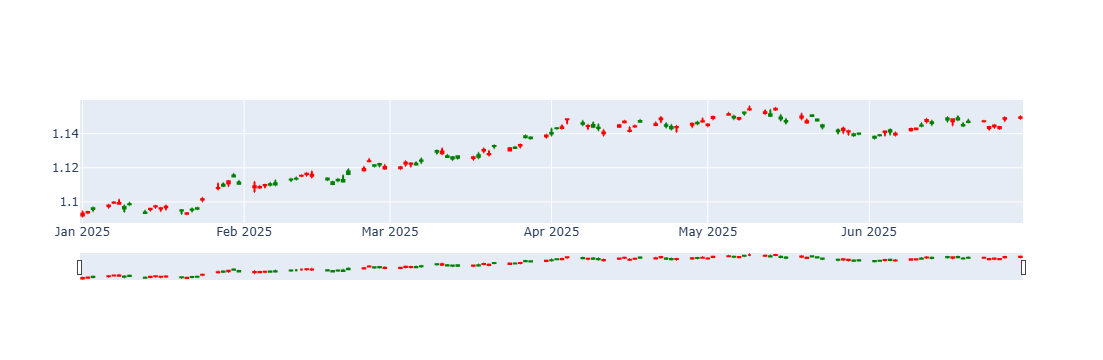

In [4]:

fig.show()

In [5]:
fig.update_layout(title = "EURUSD Candlestick Chart (Jan-Jun 2025)",
                  xaxis_title = "Date",
                  
      ##  yaxis_title = "Price", This was good too but was giving numbers upto 2 decimals, we needed to customize it to 4 hence used another approach
                  
                  yaxis = dict(title = "Price",tickformat = ".4f"), # 4 decimals
                  xaxis_rangeslider_visible = False,
                  template = "plotly_white",
                  width = 1000,
                  height = 500
                 )
fig.show()

Pattern Detection 

In [6]:
## DOJI

threshold = 0.1

## Calculating Body and Range

df["Body"] = abs(df["Close"] - df["Open"])
df["Range"] = df["High"] - df["Low"]

# Detecing Doji: body very small compared to total range


df["Doji"] = (df["Body"] / df["Range"]) < threshold

In [7]:




# Add Doji markers
doji_dates = df[df['Doji']].index
doji_prices = df[df['Doji']]['High'] + 0.0005  # place slightly above wick

fig.add_trace(go.Scatter(
    x = doji_dates,
    y = doji_prices,
    mode = 'markers',
    marker = dict(color = 'purple',
                  size = 7, 
                  symbol = 'circle',
                 line = dict(width = 1, color = 'white')
                 ),
    name = 'Doji'
))

fig.show()


Detect Bullish Engulfing Candlesticks

In [8]:
# Prev Candle:  Bearish (Close < Open)
# Current Candle: Bullish (Close > Open) AND  Current Open < Prev Close AND Current Close > Prev Open


df["Prev_Open"] = df["Open"].shift(1)
df["Prev_Close"] = df["Close"].shift(1)


# Making a Bullish Engulfing 

df["Bullish_Engulfing"] = (
    (df["Prev_Close"] < df["Prev_Open"]) &     #  Previous Red candle
    (df["Close"] > df["Open"]) &              # Current Green Candle
    (df["Prev_Close"] > df["Open"] ) &       
    (df["Prev_Open"]  < df["Close"])
)

In [9]:
engulfing_dates = df[df['Bullish_Engulfing']].index     # engulfing_dates is an array of dates on which a bullish‑engulfing candle occurs.

engulfing_lows = df[df['Bullish_Engulfing']]['Low'] - 0.0005  # WHy - 0.0005? Subtracting  a small offset so the triangle marker 
                                                             # sits just below the wick,  preventing overlap with the candle graphic.

fig.add_trace(go.Scatter(
    x=engulfing_dates,
    y=engulfing_lows,
    mode='markers',
    marker=dict(
        color='lime',
        size=9,
        symbol='triangle-up',
        line=dict(width=1, color='black')
    ),
    name='Bullish Engulfing'
))

Detect Hammer Candles

In [10]:
#  Body is small
#  Lower wick is 2x (or more) the body
#  Close is near the top of the candle



# Candle structure
df['Upper_Wick'] = df['High'] - df[['Open', 'Close']].max(axis=1)
df['Lower_Wick'] = df[['Open', 'Close']].min(axis=1) - df['Low']
df['Body_Size'] = abs(df['Close'] - df['Open'])

# Hammer conditions
df['Hammer'] = (
    (df['Lower_Wick'] >= 2 * df['Body_Size']) &
    (df['Upper_Wick'] <= df['Body_Size']) & 
    (df['Close'] > df['Open'])  # optional: only bullish hammer
)

In [11]:
hammer_dates = df[df['Hammer']].index
hammer_lows = df[df['Hammer']]['Low'] - 0.0005  # place below wick

fig.add_trace(go.Scatter(
    x=hammer_dates,
    y=hammer_lows,
    mode='markers',
    marker=dict(
        color='gold',
        size=9,
        symbol='diamond',
        line=dict(width=1, color='black')
    ),
    name='Hammer'
))

In [19]:

#  without this block the x axis was showing 1.74 * 10^18 and so on , instaead of proper dates


#  fig.update_xaxes(
#     title_text="Date",
#     type="date",
#     tickformat="%d %b",   # e.g., 15 Jan, 01 Mar
#     dtick="M1",           # every 1 month
#     tickangle=0
# )   

# This code was fine but was causing overlapping, hence tilted


In [20]:
fig.update_xaxes(
    title_text="Date",
    type="date",
    tickformat="%d %b",   # e.g., 15 Jan
    dtick="M1",           # every 1 month
    tickangle=45          # slight tilt for better readability
)

fig.write_image("eurusd_candlestick_patterns.png", scale=2)

In [21]:
df.to_csv("EURUSD_patterns_2025.csv")